# 一线城市租房有多贵，我爬取了深圳自如所有的房子告你诉答案
## 项目说明
通过对深圳自如网站上的房源情况进行探索分析，进而了解深圳自如房租的相关情况。
## 探索的问题
1. 房租的分布情况
2. 哪种户型的房源最多
3. 哪条地铁线附近的房租比较贵
4. 哪个区的房租更贵
5. 房源的面积分布情况    

## 数据说明
* 数据来源深圳自如网站(仅包含可出租状态的合租房源）
* 采用集搜客工具爬取
* house_area: 表示房间的面积
* house_toom: 表示出租房屋的户型
* house_price: 表示每月的房租
* house_name: 表示房源所处的小区
* house_located: 表示房源所处的区
* subway_info: 表示房源附近是否有地铁站

## 数据清洗
### 数据预览

In [28]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] # 使图形能够正常显示中文
%pylab inline

df_sz_ziroom = pd.read_csv('ziroom_sz.csv') # 加载数据
df_sz_ziroom.head(2) # 预览数据

Populating the interactive namespace from numpy and matplotlib


,Unnamed: 0,house_name,house_located,house_room,house_area,house_price
0,0,龙园山庄4居室-南卧,[罗湖区清水河] 3号线(龙岗线)草埔,4室1厅,15.5 ㎡,￥ 1660 ...
1,1,塘朗城广场东区5居室-北卧,[南山区大学城] 5号线(环中线)塘朗,5室1厅,24 ㎡,￥ 2230 ...


In [29]:
df_sz_ziroom = df_sz_ziroom.drop('Unnamed: 0', axis=1) # 删掉无用的列
df_sz_ziroom.head(5) # 预览前五条数据

,house_name,house_located,house_room,house_area,house_price
0,龙园山庄4居室-南卧,[罗湖区清水河] 3号线(龙岗线)草埔,4室1厅,15.5 ㎡,￥ 1660 ...
1,塘朗城广场东区5居室-北卧,[南山区大学城] 5号线(环中线)塘朗,5室1厅,24 ㎡,￥ 2230 ...
2,龙园山庄4居室-南卧,[罗湖区清水河] 3号线(龙岗线)草埔,4室1厅,15 ㎡,￥ 1830 ...
3,塘朗城广场东区5居室-南卧,[南山区大学城] 5号线(环中线)塘朗,5室1厅,6.3 ㎡,￥ 1860 ...
4,桃源村一期4居室-南卧,[南山区桃源村] 7号线桃源村,4室1厅,7.8 ㎡,￥ 1930 ...


In [30]:
df_sz_ziroom.tail(5) # 预览后5条数据

,house_name,house_located,house_room,house_area,house_price
895,龙联花园4居室-南卧,[南山区西丽] 7号线珠光,4室1厅,13.1 ㎡,￥ 1990 ...
896,愉康花园3居室-北卧,[南山区南头] 11号线南山,3室1厅,13.7 ㎡,￥ 2690 ...
897,春华四季园二期4居室-北卧,[龙华区坂田] 5号线(环中线)五和,4室1厅,9.4 ㎡,￥ 1560 ...
898,港铁天颂5居室-北卧,[龙华区龙华中心] 4号线(龙华线)龙胜,5室1厅,18 ㎡,￥ 2690 ...
899,春华四季园二期4居室-北卧,[龙华区坂田] 5号线(环中线)五和,4室1厅,9.4 ㎡,￥ 1560 ...


### 需要清洗的字段
除了 house_room 字段外，剩下的字段都需要清洗，为了便于分析还需要新增字段，工作量有点大，挺好，又可以练手。     

**1. house_area 字段有 "15.2 $m^2$" 和 "约9.5 $m^2$" 两种格式，需要转换成纯数字格式。**

In [31]:
def remove_m2(area):
    '''提取 house_area 字段中的数字'''
    if str(area).split()[0].decode('utf-8')[0].isdigit(): # 若字段中无“约”直接取 split 后的列表中的第一个子元素
        area = area.split()[0]
    else:
        area = str(area).split()[0].decode('utf-8')[1:] # 若字段中有“约”则从 split 后列表中的第一个子元素的第二个位置开始取
    return float(area)
df_sz_ziroom['house_area'] = df_sz_ziroom['house_area'].apply(remove_m2)
df_sz_ziroom['house_area'].head(5) # 预览后15条数据

0    15.5
1    24.0
2    15.0
3     6.3
4     7.8
Name: house_area, dtype: float64

**2. house_price 字段目前格式为 "￥1490  (每月)"，要把其修改为纯数字格式**

In [32]:
def remove_rmb(price):
    '''提取 house_price 字段中的数字'''
    return int(price.split()[1])
df_sz_ziroom['house_price'] = df_sz_ziroom['house_price'].apply(remove_rmb)
df_sz_ziroom['house_price'].head()

0    1660
1    2230
2    1830
3    1860
4    1930
Name: house_price, dtype: int64

**3. house_name 字段目前的格式类似为 "桦润馨居4居室-南卧"，需要把小区名字提取出来，如 "桦润馨居"**

In [33]:
def get_house_name(name):
    '''提取 house_name 字段中的小区名字'''
    return name.decode('utf-8').split('-')[0][:-3].encode('utf-8')
df_sz_ziroom['house_name'] = df_sz_ziroom['house_name'].apply(get_house_name)
df_sz_ziroom['house_name'].head()

0       龙园山庄
1    塘朗城广场东区
2       龙园山庄
3    塘朗城广场东区
4      桃源村一期
Name: house_name, dtype: object

**4. house_located 字段格式为 "[龙华区龙华中心] 4号线(龙华线)龙华" 包含所在的区和地铁两项信息，现需要把这两项信息提取并设置为两个字段**      
4.1 提取地铁信息

In [34]:
def get_subway(house_located):
    '''从 house_located 中提取地铁信息'''
    info = house_located.decode('utf-8').replace('[', ' ').replace(']', ' ').split()
    if len(info) > 1: # 判断 house_located 字段中是否包含地铁信息
        if info[1][:2].isdigit(): # 判断地铁号是否为两位数 如 11号线
            subway_info = info[1][:4].encode('utf-8') # 若地铁号为两位数，则取 split 后的列表中的第二个元素的前四位
        else:
            subway_info = info[1][:3].encode('utf-8') # 若地铁号为1位数，则取 split 后的列表中的第二个元素的前三位
    else:
        subway_info = None # 若无地铁信息则返回 None
    return subway_info
df_sz_ziroom['subway_info'] = df_sz_ziroom['house_located'].apply(get_subway) # 新建 subway 字段
df_sz_ziroom['subway_info'].head()

0    3号线
1    5号线
2    3号线
3    5号线
4    7号线
Name: subway_info, dtype: object

4.2 提取所在的区的信息

In [35]:
def house_located(house_located):
    '''从 house_located 中提取区信息'''
    info = house_located.decode('utf-8').replace('[', ' ').replace(']', ' ').split()
    return info[0][:3].encode('utf-8')
df_sz_ziroom['house_located'] = df_sz_ziroom['house_located'].apply(house_located)
df_sz_ziroom['house_located'].head()

0    罗湖区
1    南山区
2    罗湖区
3    南山区
4    南山区
Name: house_located, dtype: object

In [36]:
df_sz_ziroom.sort_values(by='house_area').head(5) # house_area 列有异常值

,house_name,house_located,house_room,house_area,house_price,subway_info
833,大塘垅小区,罗湖区,4室1厅,0.10,1690,9号线
361,勤诚达22世纪二期,宝安区,4室1厅,5.36,1530,5号线
554,皇洲花园,福田区,4室1厅,5.80,1790,1号线
650,港城华庭,福田区,4室1厅,5.90,1830,4号线
29,桃源村一期,南山区,4室1厅,5.91,1460,7号线


In [37]:
df_sz_ziroom = df_sz_ziroom.drop(df_sz_ziroom[df_sz_ziroom['house_area']==0.1].index)
df_sz_ziroom.sort_values(by='house_area').head(5)

,house_name,house_located,house_room,house_area,house_price,subway_info
361,勤诚达22世纪二期,宝安区,4室1厅,5.36,1530,5号线
554,皇洲花园,福田区,4室1厅,5.80,1790,1号线
650,港城华庭,福田区,4室1厅,5.90,1830,4号线
29,桃源村一期,南山区,4室1厅,5.91,1460,7号线
559,星河传奇一期,龙华区,3室1厅,6.00,1530,4号线


In [38]:
df_sz_ziroom.to_csv('cleaned_sz_ziroom.csv') # 清洗后的数据保存为新的 csv 文件

## 数据探索
### 1 单维度分析
**1.1 房租分布情况**

In [39]:
df_sz_ziroom['house_price'].describe()

count     899.000000
mean     2068.787542
std       465.815828
min      1130.000000
25%      1760.000000
50%      1930.000000
75%      2290.000000
max      4360.000000
Name: house_price, dtype: float64

* 最低的房租为 1130 元每月，最贵的房租为 4360 元每月，土豪专属。   
* 平均房租为 2068 元每月，75% 的房租超过 1760 元每月。         

接下来看看最高房租和最低房租的是什么房子

In [40]:
df_sz_ziroom[df_sz_ziroom['house_price'] == 1130]

,house_name,house_located,house_room,house_area,house_price,subway_info
892,金地龙城中央,龙岗区,6室1厅,12.2,1130,3号线


In [41]:
df_sz_ziroom[df_sz_ziroom['house_price'] == 4360]

,house_name,house_located,house_room,house_area,house_price,subway_info
822,滨福庭园,南山区,4室1厅,16.8,4360,2号线


* 房租最低的房子位于龙岗区，龙岗区比较偏僻，且该套房源为6室1厅，房租最低也正常。
* 房租最贵的房子位于南山区在二号线旁边，2号线经过的基本都是深圳最繁华的地带，房租这么高也正常。

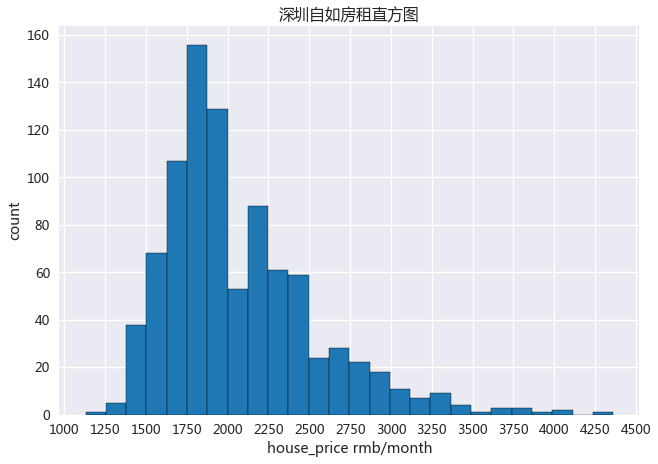

In [42]:
def delete_spines():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.style.use('seaborn-talk')
x = df_sz_ziroom['house_price']
plt.hist(x, bins=26, edgecolor='black')
new_xticks = np.linspace(1000, 4500, 15)
plt.xticks(new_xticks)
plt.xlabel("house_price rmb/month")
plt.ylabel("count")
plt.title(u"深圳自如房租直方图")
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True)
plt.show()

大部分的房价集中在 1625 到 2250 元每月，其中 1750 到 2000 元每月的房源最多。超过 3500 元每月的房源很少。因为本次分析的都是合租房源，看来深圳自如的房租还是比较贵。

**1.2 面积分布情况**

In [43]:
df_sz_ziroom['house_area'].describe()

count    899.000000
mean      11.462803
std        3.322627
min        5.360000
25%        9.200000
50%       11.100000
75%       13.300000
max       30.900000
Name: house_area, dtype: float64

最小面积为 5.36 $m^2$，最大面积为 30.9 $m^2$，平均面积为 11.46 $m^2$。看来大多数房间的面积都不是很大，真是面积又小，价格又贵。

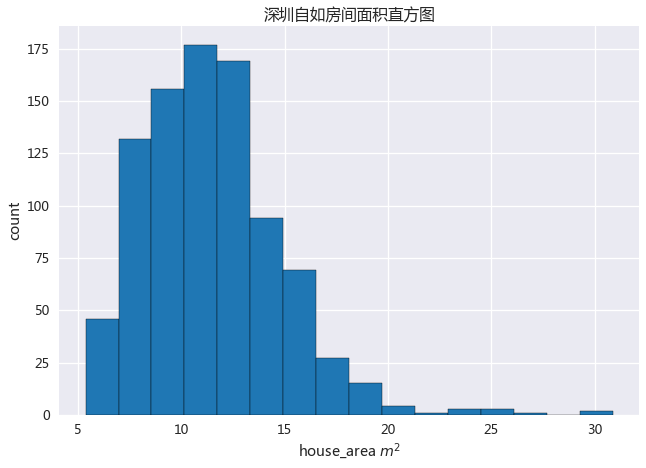

In [44]:
x = df_sz_ziroom['house_area']
plt.hist(x, bins=16, edgecolor='black')
plt.xlabel('house_area $m^2$')
plt.ylabel('count')
plt.title(u'深圳自如房间面积直方图')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True)
plt.show()

绝大多数房间的面积集中在 6.3 到 12.7 $m^2$ 之间，其中 10 到 12.7 $m^2$ 之间的房源最多。超过 20 $m^2$ 的房源很少，租房形式真严峻。

**1.3 户型分布情况**

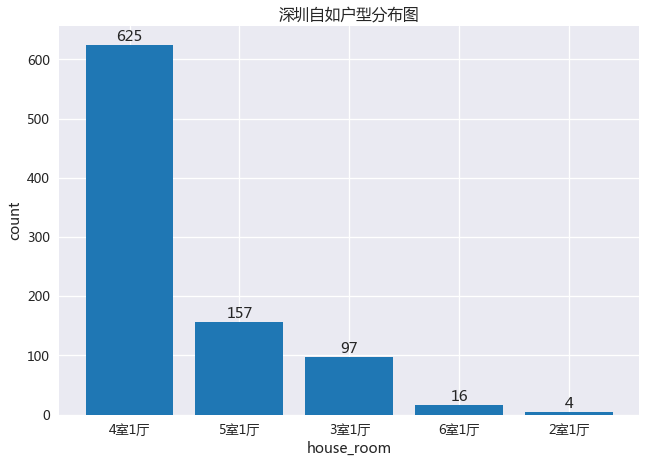

In [45]:
def add_text(x, y):
    for a, b in zip(x, y):
        plt.text(a, b+0.05, '%.0f' % b, ha='center', va='bottom', fontsize=15)

x = np.arange(len(df_sz_ziroom['house_room'].unique()))
y = df_sz_ziroom['house_room'].value_counts()
x_ticks = [room.decode('utf-8') for room in df_sz_ziroom['house_room'].unique()]
plt.bar(x, y)
plt.xticks(x, x_ticks)
plt.xlabel('house_room')
plt.ylabel('count')
plt.title(u'深圳自如户型分布图')
delete_spines()
add_text(x, y)

户型最多的为4室1厅，其次为3室1厅，最少的为2室1厅。  
户型太大，住的人太多，租客不愿意租，户型太小，自如估计赚不了多少钱，大量推出4室1厅的房源可以兼顾两方面。

**1.4 区域房源分布情况**

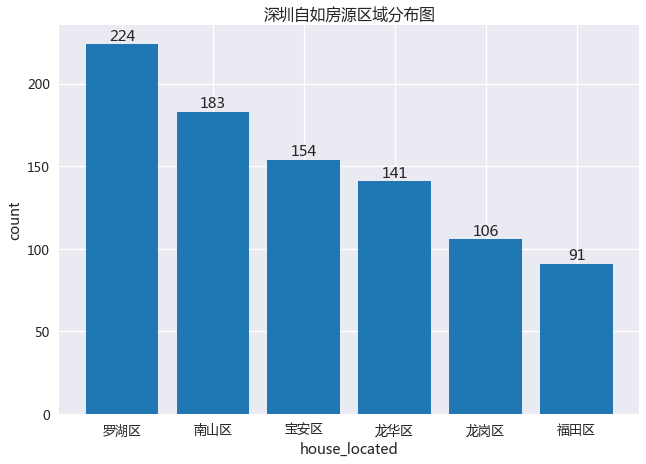

In [46]:
x = np.arange(len(df_sz_ziroom['house_located'].unique()))
y = df_sz_ziroom['house_located'].value_counts()
plt.bar(x, y)
x_ticks = [located.decode('utf-8') for located in df_sz_ziroom['house_located'].unique()]
plt.xticks(x, x_ticks)
plt.xlabel('house_located')
plt.ylabel('count')
plt.title(u'深圳自如房源区域分布图')
delete_spines()
add_text(x, y)

罗湖区的房源最多，其次是南山区，最少的是福田区。

**1.5 地铁附近房源分布图**

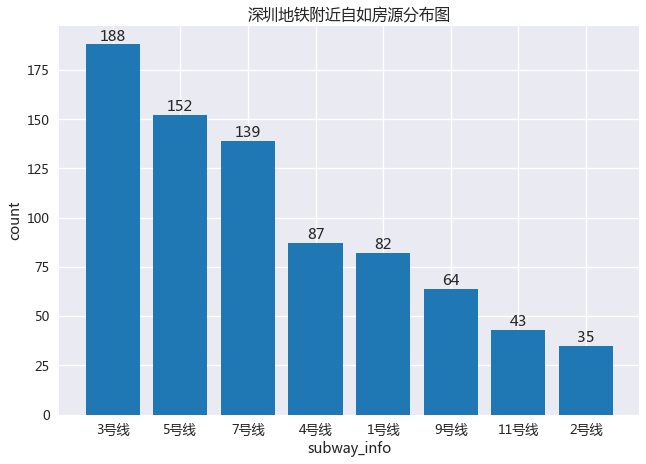

In [47]:
x = np.arange(len(df_sz_ziroom['subway_info'].dropna().unique()))
y = df_sz_ziroom['subway_info'].value_counts()
plt.bar(x, y)
x_ticks = [subway.decode('utf-8') for subway in df_sz_ziroom['subway_info'].dropna().unique()]
plt.xticks(x, x_ticks)
plt.xlabel('subway_info')
plt.ylabel('count')
plt.title(u'深圳地铁附近自如房源分布图')
delete_spines()
add_text(x, y)

3号线附近的房源最多，由于3号线终点和起点分别在罗湖和龙岗，在罗湖上班的话，沿着3号线租房最好，不仅房源多，而且龙岗的房租普遍比较便宜，上班地铁直达。   
5号线附近房源数量排在第二位，由于5号线横跨罗湖区、南山区、宝安区，中途换成站非常多，不论在罗湖还是南山还是宝安区，沿着5号线附近租房也是不错的选择。

**1.6 小区数量分布图**

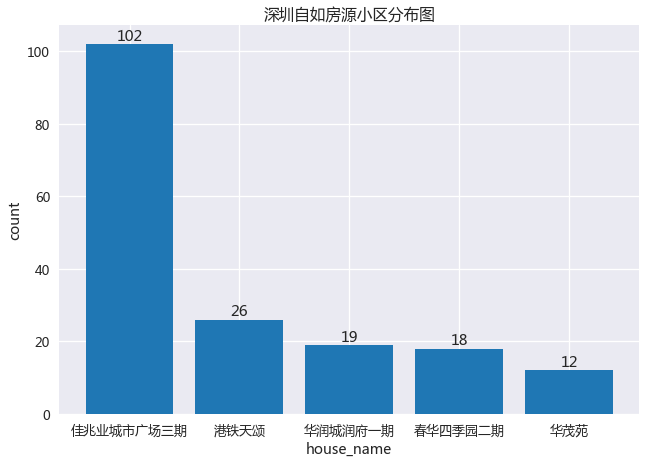

In [48]:
x = np.arange(len(df_sz_ziroom['house_name'].value_counts().head(5).index))
y = df_sz_ziroom['house_name'].value_counts().head(5)
plt.bar(x, y)
x_ticks = [name.decode('utf-8') for name in df_sz_ziroom['house_name'].value_counts().head(5).index]
plt.xticks(x, x_ticks)
plt.xlabel('house_name')
plt.ylabel('count')
plt.title(u'深圳自如房源小区分布图')
delete_spines()
add_text(x, y)

房源最多的小区为佳兆业城市广场三期，数量高达102套，其次为港铁天颂。    
佳兆业城市广场三期位于华为基地附近，在华为上班去该小区租房是个不错的选择。    
港铁天颂位于深圳北高铁站附近，需要经常坐高铁出差去该小区租房是个不错的选择。

### 2 双维度分析
**2.1 面积和房租**

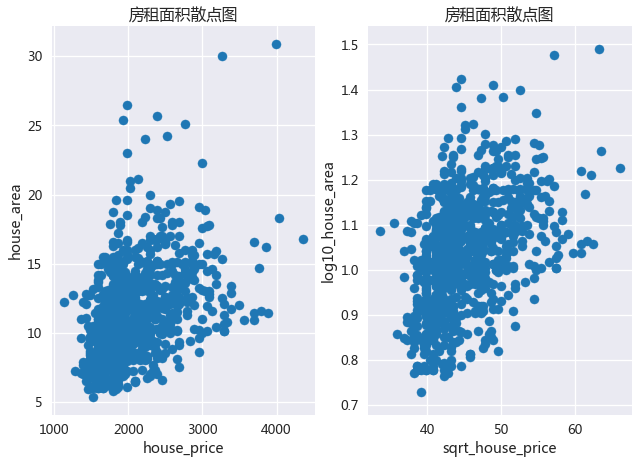

In [49]:
x = df_sz_ziroom['house_price']
y = df_sz_ziroom['house_area']
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.scatter(x, y)
ax1.set_xlabel('house_price')
ax1.set_ylabel('house_area')
ax1.set_title(u'房租面积散点图')

ax2.scatter(sqrt(x), log10(y))
ax2.set_xlabel('sqrt_house_price')
ax2.set_ylabel('log10_house_area')
ax2.set_title(u'房租面积散点图')
plt.show()

* 图1为房子的面积和总价的关系图      
* 图2为对面积和总计分别取平方根和对数的关系图    
从图2中发现面积和房租并没有呈现出明显的线性关系，并不是房间面积越大，房租越贵。

**2.2 区域和房租**

In [50]:
df_located_price = df_sz_ziroom.loc[:,['house_located', 'house_price']]
df_located_price = df_located_price.groupby('house_located')['house_price']\
                                .apply(pd.Series.reset_index, drop=True).unstack()
df_located_price.head()

,0,1,2,3,4,5,6,7,8,9,...,214,215,216,217,218,219,220,221,222,223
house_located,,,,,,,,,,,,,,,,,,,,,
南山区,2230.0,1860.0,1930.0,1830.0,2260.0,1460.0,1660.0,2190.0,2090.0,2290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
宝安区,2130.0,1790.0,2030.0,1690.0,1790.0,1690.0,1790.0,1790.0,2130.0,2430.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
福田区,2360.0,2230.0,2990.0,2260.0,2690.0,2360.0,2030.0,2090.0,3490.0,3990.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
罗湖区,1660.0,1830.0,2260.0,1990.0,1660.0,1830.0,1890.0,1890.0,2230.0,2190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
龙华区,1990.0,1890.0,1690.0,1860.0,1830.0,2390.0,1630.0,1990.0,1890.0,1860.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


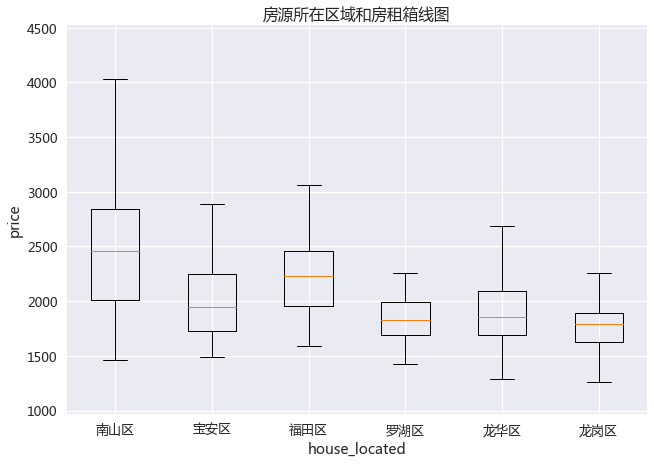

In [51]:
xs = [x[~np.isnan(x)] for x in df_located_price.values]
plt.boxplot(xs)
x_ticks = [tick.decode('utf-8') for tick in df_located_price.index]
plt.xticks(arange(1, len(xs)+1), x_ticks)
y_ticks = np.linspace(1000, 4500, 8)
plt.yticks(y_ticks)
plt.xlabel('house_located')
plt.ylabel('price')
plt.title(u'房源所在区域和房租箱线图')
plt.gca().yaxis.grid(True)
delete_spines()
plt.show()

南山区的房租贵，75%的房租高于2000元每月，其箱体也最长。南山区积聚了大量互联网企业，薪资水平在深圳相对来说也非常高。    
福田区的房租紧随南山区之后，龙岗区和罗湖区的房租最低。   
如果在南山区工作，去宝安租房是个不错的选择，地铁方便，房租也比南山便宜。    
在福田区工作，去罗湖和龙华租房是个不错的选择，地铁方便，房租也比福田便宜很多。

**2.2 地铁沿线房租情况**

In [52]:
df_subway_price = df_sz_ziroom.loc[:,['subway_info', 'house_price']]
df_subway_price.head()
df_subway_price = df_subway_price.groupby('subway_info')['house_price']\
                                .apply(pd.Series.reset_index, drop=True).unstack()
df_subway_price.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
subway_info,,,,,,,,,,,,,,,,,,,,,
11号线,2630.0,2130.0,2460.0,2790.0,1630.0,2090.0,3030.0,3060.0,2090.0,1790.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1号线,1790.0,2030.0,1690.0,1790.0,1690.0,1790.0,1790.0,2130.0,2430.0,1990.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2号线,1890.0,2860.0,2660.0,2030.0,2590.0,2890.0,2990.0,2230.0,2360.0,3060.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3号线,1660.0,1830.0,1990.0,1690.0,2360.0,2260.0,1660.0,1830.0,2260.0,2230.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4号线,1690.0,1860.0,1830.0,1630.0,1990.0,1590.0,2190.0,1830.0,2290.0,1790.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


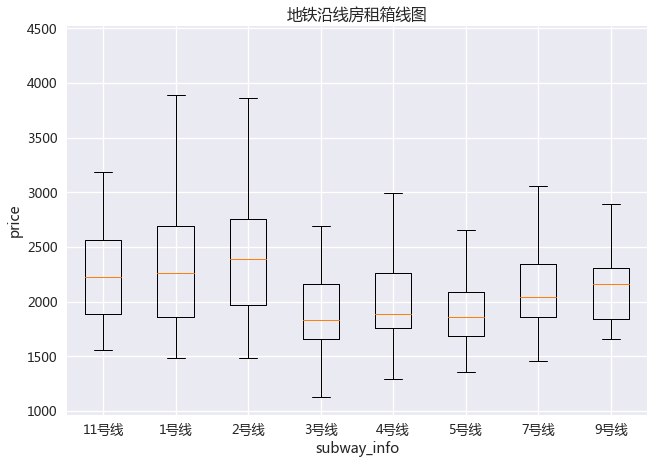

In [53]:
xs = [x[~np.isnan(x)] for x in df_subway_price.values]
plt.boxplot(xs)
x_ticks = [tick.decode('utf-8') for tick in df_subway_price.index]
plt.xticks(arange(1, len(xs)+1), x_ticks)
plt.gca().yaxis.grid(True)
plt.xlabel('subway_info')
plt.ylabel('price')
plt.title(u'地铁沿线房租箱线图')
delete_spines()
plt.show()

2号线沿线的房租最贵，绝大部分都超过2000元每月，2号线沿线都是比较繁华的地方，房租自然比较高。1号线和11号线沿线的房租紧随2号线其后。   
3号线和5号线沿线的房租比较低。

### 3 多维度分析
**3.1 面积，房租，区域，地铁沿线**

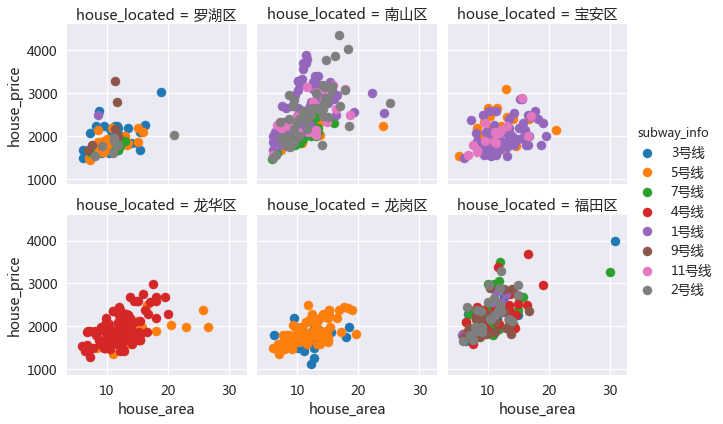

In [54]:
import sys
default_stdout = sys.stdout
default_stderr = sys.stderr
reload(sys)
sys.stdout = default_stdout
sys.stderr= default_stderr
sys.setdefaultencoding('utf8')
import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['Microsoft YaHei']})
sns.FacetGrid(df_sz_ziroom, col='house_located', col_wrap= 3,
                        hue='subway_info',size=3, aspect=1)\
                    .map(plt.scatter, "house_area", "house_price")\
                    .add_legend()  
plt.show()

9号线沿线的房子最贵，主要分布在南山区和福田区，绝大多数房租均超过2000元每月。     
5号线和3号线沿线的房子主要分布在罗湖区和龙岗区，且绝大多数房价低于2000元每月。5号线沿线少量的大面积房源分布子在龙华区。     
7号线和2号线沿线的房子主要分布在南山区和罗湖区，房源数量比较少，且价格大多数超过2000元每月。      
4号线沿线的房子绝大部分分布在龙华区，绝大部分价格比较高分布在福田区。     
1号线和11号线沿线的房子主要分布南山区和宝安区，分布在宝安区的房租相对来说比较低。   

## 结论
1. 深圳自如绝大多数房租超过1700元，且面积都不大，不过结合深圳的实际租房情况和自如的服务，这个价位还是可以考虑。
2. 南山区的房租最贵，房源数量也是第二多的，南山区也聚集了大量互联网企业，对于经常加班的互联网从业者来说在公司附近租房是个不错的选择。
3. 龙岗区和罗湖区的房租最低，且罗湖区房源数量最多，在罗湖上班想租的近一点可以选择罗湖，考虑便宜一点的可以去龙岗区租房。